In [1]:
from google.colab import drive
drive.mount('/content/drive')
import torch


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Week 9: Using Transformer Models


## Getting started
If working on your own machine, make sure the huggingface transformers package is installed

`conda install -c huggingface transformers`

or

`pip install transformers`

Of course, if working on Google Colab, you won't need to do this.  Whatever environment you are using check whether the following code runs.  It should output a negative label with a high score!


In [ ]:
from transformers import pipeline
print(pipeline('sentiment-analysis')('I hate love'))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'NEGATIVE', 'score': 0.9006491899490356}]


In [ ]:
print(pipeline('sentiment-analysis')('I love hate'))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'NEGATIVE', 'score': 0.9899576306343079}]


The following is adapted from an older version of the huggingface quickstart to transformers tutorial
https://huggingface.co/transformers/v2.4.0/quickstart.html
We will be looking at the BERT introduction (but feel free to have a look at GPT2 etc as well!)

First of all we need some key imports.  We are going to be using the pre-trained bert-base-uncased model so this cell instantiates a tokenizer for this model.  Logging is also switched on so we can see more of what's going on. The first time you run it, the model will be downloaded and cached.  The cached version will be used on subsequent runs, if it is available (not on Google CoLab).

In [ ]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening under the hood, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Now we are going to tokenize some text.  This will demonstrate the 'wordpiece' vocabulary used by BERT as well as the fact that we need to introduce special `[CLS]` and `[SEP]` tokens in the input.

In [ ]:
# Tokenize input
text = "[CLS] Who was elected as British prime minister in 1951? [SEP] Sir Winston Leonard Spencer Churchill was a British politician, statesman, army officer and writer, who was Prime Minister of the United Kingdom from 1940 to 1945 and again from 1951 to 1955. [SEP]"
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)

['[CLS]', 'who', 'was', 'elected', 'as', 'british', 'prime', 'minister', 'in', '1951', '?', '[SEP]', 'sir', 'winston', 'leonard', 'spencer', 'churchill', 'was', 'a', 'british', 'politician', ',', 'statesman', ',', 'army', 'officer', 'and', 'writer', ',', 'who', 'was', 'prime', 'minister', 'of', 'the', 'united', 'kingdom', 'from', '1940', 'to', '1945', 'and', 'again', 'from', '1951', 'to', '1955', '.', '[SEP]']


In [ ]:
# Tokenize input
text = "[CLS] What are igneous rocks? [SEP] Igneous rocks form when hot , molten rock crystallizes and solidifies. [SEP] "
tokenized_text= tokenizer.tokenize(text)
print(tokenized_text)

['[CLS]', 'what', 'are', 'ign', '##eous', 'rocks', '?', '[SEP]', 'ign', '##eous', 'rocks', 'form', 'when', 'hot', ',', 'molten', 'rock', 'crystal', '##li', '##zes', 'and', 'solid', '##ifies', '.', '[SEP]']


Note that the tokenizer is not breaking down all words according to their morphology -- only rare words.  Reasonably frequent words such as `elected` are left as whole words.  Rarer words such as `solidifies` are broken down.

Now we are going to mask out one of the words in the text.  For the purposes of this demonstration, I have chosen token 11 but you could try different tokens.  Remember that during training the tokens to mask are chosen randomly.


In [ ]:
# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
print(tokenized_text)

['[CLS]', 'what', 'are', 'ign', '##eous', 'rocks', '?', '[SEP]', '[MASK]', '##eous', 'rocks', 'form', 'when', 'hot', ',', 'molten', 'rock', 'crystal', '##li', '##zes', 'and', 'solid', '##ifies', '.', '[SEP]']


In [ ]:
print(len(tokenized_text))

25


We are now going to try to use the masked language model to predict this word.

First we need to convert the input into a list of word index ids.

In [ ]:
# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
print(indexed_tokens)
print(indexed_tokens[11])

# seems special tokens are 101 (CLS), 102 (), 103

[101, 2054, 2024, 16270, 14769, 5749, 1029, 102, 103, 14769, 5749, 2433, 2043, 2980, 1010, 23548, 2600, 6121, 3669, 11254, 1998, 5024, 14144, 1012, 102]
2433


We need segment ids to define whether a token is in the first or second sentence.

In [ ]:
def make_segment_ids(list_of_tokens):
    #this function assumes that up to and including the first '[SEP]' is the first segment, anything afterwards is the second segment
    current_id=0
    segment_ids=[]
    for token in list_of_tokens:
        segment_ids.append(current_id)
        if token == '[SEP]':
            current_id+=1
    return segment_ids

segment_ids=make_segment_ids(tokenized_text)
print(segment_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# Convert inputs to PyTorch tensors
#this just wraps things up in multi-dimensional tensors rather than as flat lists.
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segment_ids])
print(tokens_tensor)
print(segments_tensors)
print(tokens_tensor.shape)
print(segments_tensors.shape)

tensor([[  101,  2054,  2024, 16270, 14769,  5749,  1029,   102,   103, 14769,
          5749,  2433,  2043,  2980,  1010, 23548,  2600,  6121,  3669, 11254,
          1998,  5024, 14144,  1012,   102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]])
torch.Size([1, 25])
torch.Size([1, 25])


Now we need to encode the input using the bert-base-uncased model


In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Set the model in evaluation mode to deactivate the DropOut modules
# This is IMPORTANT to have reproducible results during evaluation!

model.eval()

# If you have a GPU, put everything on cuda - otherwise comment this out to run on CPU
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
model.to('cuda')

# Predict hidden states features for each layer
with torch.no_grad():
    # See the models docstrings for the detail of the inputs
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)

    # Transformers models always output tuples.
    # See the models docstrings for the detail of all the outputs
    # In our case, the first element of outputs is the output of the last layer of the Bert model (all tokens)
    # the second element of outputs, outputs[1] is actually just a "pooled_output" representation of the CLS token (rather than all tokens) - however this involves an extra layer which is why it is not the same as the first element in outputs[0]!
    encoded_layers = outputs[0]
# We have encoded our input sequence in a FloatTensor of shape (batch size, sequence length, model hidden dimension)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# We have encoded our input sequence in a FloatTensor of shape (batch size, sequence length, model hidden dimension)
print(encoded_layers.shape)

torch.Size([1, 25, 768])


In [ ]:
encoded_layers

tensor([[[-0.7295,  0.9521, -0.4791,  ..., -0.5437,  0.1315,  0.6965],
         [ 0.3421, -0.0885, -0.0069,  ...,  0.1188, -0.3545, -0.9848],
         [ 0.3834,  0.3104,  0.5548,  ..., -0.3719, -0.1121,  0.6191],
         ...,
         [ 0.2454,  0.5818, -0.0600,  ..., -0.4715, -0.4633, -0.2814],
         [ 0.6077, -0.0073, -0.2707,  ...,  0.0576, -0.5776, -0.4525],
         [ 0.6224, -0.0182, -0.2529,  ...,  0.0608, -0.5859, -0.4302]]],
       device='cuda:0')

In [ ]:
#outputs[1] is a representation of the CLS token of shape (batch size, model hidden dimension)
outputs[1].shape

torch.Size([1, 768])

In [ ]:
outputs[1].shape

torch.Size([1, 768])

We can also predict the masked token as follows.  We make the predictions as before (using the last layer of the BERT model) but then we find the token id which maximises the prediction for the masked token.

In [ ]:
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
model.to('cuda')

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]


# # find the token id which maximises the prediction for the masked token and then convert this back to a word
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
print(predicted_token)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ign


Did BERT correctly predict the masked token?

### Exercise 0
Mask each token in turn and see what BERT predicts.   How accurate are its predictions?  As an extension, you could look at masking multiple words in the sequence.

In [ ]:
# Tokenize input
text = "[CLS] What are igneous rocks? [SEP] Igneous rocks form when hot , molten rock crystallizes and solidifies. [SEP] "
tokenized_text= tokenizer.tokenize(text)
target_text = [word for word in tokenized_text if word not in ['[CLS]', '[SEP]']]
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
segment_ids=make_segment_ids(tokenized_text)
model.eval()
model.to('cuda')

print(tokenized_text)
print(target_text)

predos = []

for i in range(1, len(tokenized_text)):
  tokenized_text= tokenizer.tokenize(text)
  tokenized_text[i] = '[MASK]'

  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segment_ids])
    # If you have a GPU, put everything on cuda
  tokens_tensor = tokens_tensor.to('cuda')
  segments_tensors = segments_tensors.to('cuda')

  # Predict all tokens
  with torch.no_grad():
      outputs = model(tokens_tensor, token_type_ids=segments_tensors)
      predictions = outputs[0]


  # # find the token id which maximises the prediction for the masked token and then convert this back to a word
  predicted_index = torch.argmax(predictions[0, i]).item()
  predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
  print(predicted_token)
  predos.append(predicted_token)

print(predos)
print(target_text)

# total = sum([1 for word in i, word in enumerate()])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['[CLS]', 'what', 'are', 'ign', '##eous', 'rocks', '?', '[SEP]', 'ign', '##eous', 'rocks', 'form', 'when', 'hot', ',', 'molten', 'rock', 'crystal', '##li', '##zes', 'and', 'solid', '##ifies', '.', '[SEP]']
['what', 'are', 'ign', '##eous', 'rocks', '?', 'ign', '##eous', 'rocks', 'form', 'when', 'hot', ',', 'molten', 'rock', 'crystal', '##li', '##zes', 'and', 'solid', '##ifies', '.']
what
about
ign
##eous
rocks
?
"
ign
##eous
rocks
form
when
solid
,
hard
rock
crystal
##li
##zes
and
solid
##ifies
.
"
['what', 'about', 'ign', '##eous', 'rocks', '?', '"', 'ign', '##eous', 'rocks', 'form', 'when', 'solid', ',', 'hard', 'rock', 'crystal', '##li', '##zes', 'and', 'solid', '##ifies', '.', '"']
['what', 'are', 'ign', '##eous', 'rocks', '?', 'ign', '##eous', 'rocks', 'form', 'when', 'hot', ',', 'molten', 'rock', 'crystal', '##li', '##zes', 'and', 'solid', '##ifies', '.']


In [ ]:
import random

text = "[CLS] What are igneous rocks? [SEP] Igneous rocks form when hot , molten rock crystallizes and solidifies. [SEP] "
tokenized_text= tokenizer.tokenize(text)




model = BertForMaskedLM.from_pretrained('bert-base-uncased')
segment_ids=make_segment_ids(tokenized_text)

print(segment_ids)
model.eval()
model.to('cuda')

ints = set([])

while len(ints) < 2:
  num = random.randint(1, len(tokenized_text)-1)
  if tokenized_text[num] not in ['[CLS]', '[SEP]']:
    ints.add(num)

mask_ix_1, mask_ix_2 = ints
original_1 = tokenized_text[mask_ix_1]
original_2 = tokenized_text[mask_ix_2]

print(tokenized_text)
print(mask_ix_1, original_1)
print(mask_ix_2, original_2)

tokenized_text[mask_ix_1] = '[MASK]'
tokenized_text[mask_ix_2] = '[MASK]'
print(tokenized_text)


indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segment_ids])
  # If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]


# # find the token id which maximises the prediction for the masked token and then convert this back to a word
predicted_index_1 = torch.argmax(predictions[0, mask_ix_1]).item()
predicted_token_1 = tokenizer.convert_ids_to_tokens([predicted_index_1])[0]
predicted_index_2 = torch.argmax(predictions[0, mask_ix_2]).item()
predicted_token_2 = tokenizer.convert_ids_to_tokens([predicted_index_2])[0]

print(f'm1 original: {original_1} predicted: {predicted_token_1}')
print(f'm2 original: {original_2} predicted: {predicted_token_2}')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['[CLS]', 'what', 'are', 'ign', '##eous', 'rocks', '?', '[SEP]', 'ign', '##eous', 'rocks', 'form', 'when', 'hot', ',', 'molten', 'rock', 'crystal', '##li', '##zes', 'and', 'solid', '##ifies', '.', '[SEP]']
20 and
5 rocks
['[CLS]', 'what', 'are', 'ign', '##eous', '[MASK]', '?', '[SEP]', 'ign', '##eous', 'rocks', 'form', 'when', 'hot', ',', 'molten', 'rock', 'crystal', '##li', '##zes', '[MASK]', 'solid', '##ifies', '.', '[SEP]']
m1 original: and predicted: and
m2 original: rocks predicted: rocks


## Representing Sentential Meaning
We are going to be looking at different strategies for representing sentential meaning
* CLS token representation
* centroid/sum of output embeddings

The file `examples.txt` contains some example sentences.

### Exercise 1
Read in the sentences and store them as a list of sentences.  Add `[CLS]` and `[SEP]` tokens to the beginning and end of each and then pass them through the bert-base-uncased tokenizer

In [ ]:
path = '/content/drive/MyDrive/MSc/modules/2.2/2.2-Language P-2/week9-fine_tuning/lab9resources/examples.txt'

In [ ]:
data = open(path, 'r').read().split("\n")


In [ ]:
data

['The boy kicks the ball.',
 'The ball kicks the boy.',
 'The child kicks the ball.',
 'The ball is kicked by the boy.',
 'The ball is kicked.',
 'The boy kicks.',
 'The child kicks.',
 'The boy kicks a round object.',
 'The male child kicks the ball.',
 'The boy is playing football.',
 'The boy hits the ball.',
 'The ball hits the boy.',
 'The boy is hit by the ball.',
 'The ball is hit by the boy.',
 'The female child kicks the ball.',
 'The girl kicks the ball.',
 'The child plays with dolls.',
 'The female child plays with dolls.',
 'The male child plays with dolls.',
 'The girl plays with dolls.',
 'The boy plays with dolls.',
 'The boy is kicking the ball.',
 'The boy is not kicking the ball.',
 'All boys kick balls.',
 'Every boy kicks a ball.',
 'There is a boy kicking a ball.',
 'There is not a boy kicking a ball.',
 'I can see a boy kicking a ball.',
 'I cannot see a boy kicking a ball.',
 'I believe the boy is kicking the ball.',
 'No boys kick balls.',
 'Boys do not kick ba

In [ ]:
new_data_with_special_tokens = ["[CLS] " + sent + ' [SEP]' for sent in data]
new_data_with_special_tokens

['[CLS] The boy kicks the ball. [SEP]',
 '[CLS] The ball kicks the boy. [SEP]',
 '[CLS] The child kicks the ball. [SEP]',
 '[CLS] The ball is kicked by the boy. [SEP]',
 '[CLS] The ball is kicked. [SEP]',
 '[CLS] The boy kicks. [SEP]',
 '[CLS] The child kicks. [SEP]',
 '[CLS] The boy kicks a round object. [SEP]',
 '[CLS] The male child kicks the ball. [SEP]',
 '[CLS] The boy is playing football. [SEP]',
 '[CLS] The boy hits the ball. [SEP]',
 '[CLS] The ball hits the boy. [SEP]',
 '[CLS] The boy is hit by the ball. [SEP]',
 '[CLS] The ball is hit by the boy. [SEP]',
 '[CLS] The female child kicks the ball. [SEP]',
 '[CLS] The girl kicks the ball. [SEP]',
 '[CLS] The child plays with dolls. [SEP]',
 '[CLS] The female child plays with dolls. [SEP]',
 '[CLS] The male child plays with dolls. [SEP]',
 '[CLS] The girl plays with dolls. [SEP]',
 '[CLS] The boy plays with dolls. [SEP]',
 '[CLS] The boy is kicking the ball. [SEP]',
 '[CLS] The boy is not kicking the ball. [SEP]',
 '[CLS] All bo

In [ ]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Tokenizing, adding special tokens, and padding in one step using `tokenizer`
# max_length = 20  # Define the maximum length for padding
tokenized_data_with_padding = tokenizer(data, padding='longest', truncation=True, return_tensors="pt")
tokenized_data_with_padding
# tokenised_data = [tokenizer.tokenize(sent) for sent in new_data_with_special_tokens]

{'input_ids': tensor([[  101,  1996,  2879, 14590,  1996,  3608,  1012,   102,     0,     0,
             0,     0],
        [  101,  1996,  3608, 14590,  1996,  2879,  1012,   102,     0,     0,
             0,     0],
        [  101,  1996,  2775, 14590,  1996,  3608,  1012,   102,     0,     0,
             0,     0],
        [  101,  1996,  3608,  2003,  6476,  2011,  1996,  2879,  1012,   102,
             0,     0],
        [  101,  1996,  3608,  2003,  6476,  1012,   102,     0,     0,     0,
             0,     0],
        [  101,  1996,  2879, 14590,  1012,   102,     0,     0,     0,     0,
             0,     0],
        [  101,  1996,  2775, 14590,  1012,   102,     0,     0,     0,     0,
             0,     0],
        [  101,  1996,  2879, 14590,  1037,  2461,  4874,  1012,   102,     0,
             0,     0],
        [  101,  1996,  3287,  2775, 14590,  1996,  3608,  1012,   102,     0,
             0,     0],
        [  101,  1996,  2879,  2003,  2652,  2374,  1012,  

In [ ]:
tokenized_data_with_padding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

When encoding sentences, it is actually more typical to pool the hidden states for each layer (at depth n) rather than the output layer.  We can access the hidden states of the model using `output_hidden_states=True`

In [ ]:
tokens_tensor = tokenized_data_with_padding['input_ids']
segments_tensor = tokenized_data_with_padding['token_type_ids']
attention_mask = tokenized_data_with_padding['attention_mask']


#   # If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensor = segments_tensor.to('cuda')
attention_mask = attention_mask.to('cuda')

In [ ]:
print(tokens_tensor)

tensor([[  101,   101,  1996,  2879, 14590,  1996,  3608,  1012,   102,   102,
             0,     0,     0,     0],
        [  101,   101,  1996,  3608, 14590,  1996,  2879,  1012,   102,   102,
             0,     0,     0,     0],
        [  101,   101,  1996,  2775, 14590,  1996,  3608,  1012,   102,   102,
             0,     0,     0,     0],
        [  101,   101,  1996,  3608,  2003,  6476,  2011,  1996,  2879,  1012,
           102,   102,     0,     0],
        [  101,   101,  1996,  3608,  2003,  6476,  1012,   102,   102,     0,
             0,     0,     0,     0],
        [  101,   101,  1996,  2879, 14590,  1012,   102,   102,     0,     0,
             0,     0,     0,     0],
        [  101,   101,  1996,  2775, 14590,  1012,   102,   102,     0,     0,
             0,     0,     0,     0],
        [  101,   101,  1996,  2879, 14590,  1037,  2461,  4874,  1012,   102,
           102,     0,     0,     0],
        [  101,   101,  1996,  3287,  2775, 14590,  1996,  3608,

In [ ]:
print(tokens_tensor.shape)
segments_tensor.shape

torch.Size([35, 14])


torch.Size([35, 14])

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()
model.to('cuda')

# Predict hidden states features for each layer
with torch.no_grad():
    # See the models docstrings for the detail of the inputs
    outputs = model(tokens_tensor, token_type_ids=segments_tensor, attention_mask=attention_mask, output_hidden_states=True)




In [ ]:
print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0222,  0.4350, -0.1666,  ..., -0.4522,  0.3209,  0.7503],
         [ 0.0354,  0.4723, -0.1703,  ..., -0.4514,  0.2817,  0.7175],
         [ 0.1250, -0.4466, -0.0496,  ...,  0.0627,  0.2700, -0.2943],
         ...,
         [-0.0646, -0.1819,  0.1021,  ...,  0.5458,  0.1221, -0.0242],
         [-0.1207, -0.1896,  0.1418,  ...,  0.5249,  0.1008,  0.0267],
         [-0.2354, -0.2821,  0.1301,  ...,  0.4782, -0.0190,  0.0485]],

        [[-0.2512,  0.3703, -0.2641,  ..., -0.4128,  0.2703,  0.7338],
         [-0.1858,  0.4117, -0.2762,  ..., -0.4045,  0.2382,  0.7222],
         [-0.2688, -0.3773, -0.0233,  ..., -0.3562,  0.0146, -0.3649],
         ...,
         [-0.2032, -0.1854,  0.0228,  ...,  0.4484,  0.1206,  0.0245],
         [-0.2499, -0.1866,  0.0540,  ...,  0.4226,  0.0932,  0.0563],
         [-0.3329, -0.2646,  0.0352,  ...,  0.3983, -0.0114,  0.0777]],

        [[-0.1992,  0.3791, -0.0838,  ..., -0.4525,  

In [ ]:
print(len(outputs[0])) # the output embeddings for each token for each sentence
print(len(outputs[1])) # representation of the FIRST TOKEN ([CLS]) for each sentence
print(len(outputs[2])) # output of the hidden layers in the model where index 0 is the first and index -1 is the last (in this case that is index 13)

35
35
13


In [ ]:
print(len(outputs))
for i in range(len(outputs)):
    try:
        print(outputs[i].shape)
    except:
        print(len(outputs[i]))

3
torch.Size([35, 14, 768])
torch.Size([35, 768])
13


Here:
* outputs[0] contains the output representation of each token
* outputs[1] is representation of the first token (after being put through an additional layer)
* outputs[2] is a a tuple.  Each element is the hidden layer at depth n.  If we want the last layer then we need outputs[2][-1]


In [ ]:
outputs[2][0]

tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [ 0.2239, -0.1747, -0.4094,  ...,  0.2746,  0.3853,  0.0379],
         [-0.7790,  0.4781,  0.0859,  ..., -0.2489,  0.5078, -0.5689],
         ...,
         [ 0.0075, -0.4709, -0.2825,  ...,  0.2228, -0.0513,  0.2916],
         [-0.0654, -0.4484, -0.0233,  ...,  0.1875, -0.3067,  0.3197],
         [-0.1274, -0.4593,  0.0020,  ...,  0.1607, -0.1774,  0.3316]],

        [[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [ 0.2239, -0.1747, -0.4094,  ...,  0.2746,  0.3853,  0.0379],
         [-0.7790,  0.4781,  0.0859,  ..., -0.2489,  0.5078, -0.5689],
         ...,
         [ 0.0075, -0.4709, -0.2825,  ...,  0.2228, -0.0513,  0.2916],
         [-0.0654, -0.4484, -0.0233,  ...,  0.1875, -0.3067,  0.3197],
         [-0.1274, -0.4593,  0.0020,  ...,  0.1607, -0.1774,  0.3316]],

        [[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [ 0.2239, -0.1747, -0.4094,  ...,  0

In [ ]:
#outputs[2][-1] is the last hidden layer also output as outputs[0]
outputs[2][-1]

tensor([[[-0.0222,  0.4350, -0.1666,  ..., -0.4522,  0.3209,  0.7503],
         [ 0.0354,  0.4723, -0.1703,  ..., -0.4514,  0.2817,  0.7175],
         [ 0.1250, -0.4466, -0.0496,  ...,  0.0627,  0.2700, -0.2943],
         ...,
         [-0.0646, -0.1819,  0.1021,  ...,  0.5458,  0.1221, -0.0242],
         [-0.1207, -0.1896,  0.1418,  ...,  0.5249,  0.1008,  0.0267],
         [-0.2354, -0.2821,  0.1301,  ...,  0.4782, -0.0190,  0.0485]],

        [[-0.2512,  0.3703, -0.2641,  ..., -0.4128,  0.2703,  0.7338],
         [-0.1858,  0.4117, -0.2762,  ..., -0.4045,  0.2382,  0.7222],
         [-0.2688, -0.3773, -0.0233,  ..., -0.3562,  0.0146, -0.3649],
         ...,
         [-0.2032, -0.1854,  0.0228,  ...,  0.4484,  0.1206,  0.0245],
         [-0.2499, -0.1866,  0.0540,  ...,  0.4226,  0.0932,  0.0563],
         [-0.3329, -0.2646,  0.0352,  ...,  0.3983, -0.0114,  0.0777]],

        [[-0.1992,  0.3791, -0.0838,  ..., -0.4525,  0.3065,  0.7264],
         [-0.1473,  0.4120, -0.0855,  ..., -0

In [ ]:
#so if you want the penultimate hidden layer you need outputs[2][-2]
outputs[2][-2]

tensor([[[-2.3052e-01, -1.9455e-02, -3.3696e-01,  ..., -1.0996e-01,
           3.5224e-02,  9.1436e-01],
         [-1.0255e-01,  4.2619e-02, -3.1526e-01,  ..., -1.2550e-01,
          -2.1793e-02,  8.3317e-01],
         [-3.3350e-01, -7.1427e-01,  9.5124e-03,  ...,  4.2890e-01,
           2.6047e-01, -6.1668e-02],
         ...,
         [-1.9784e-01, -5.3213e-01,  2.0185e-01,  ...,  1.1356e-01,
           1.4740e-02,  3.0747e-01],
         [-3.5045e-01, -5.7603e-01,  1.9526e-01,  ...,  4.2583e-02,
          -6.1010e-02,  4.4172e-01],
         [-5.7925e-01, -6.9916e-01,  1.2533e-01,  ..., -9.8712e-02,
          -2.5070e-01,  5.3470e-01]],

        [[-5.2280e-01, -7.5248e-02, -3.3911e-01,  ..., -3.1736e-01,
          -6.5462e-02,  9.6162e-01],
         [-3.9411e-01, -6.8650e-04, -3.3913e-01,  ..., -3.0626e-01,
          -1.1269e-01,  9.0455e-01],
         [-4.8937e-01, -6.9643e-01,  1.2805e-01,  ..., -2.0759e-01,
          -2.7441e-02, -1.7423e-01],
         ...,
         [-3.8876e-01, -5

### Exercise 2
* Encode each sentence using the output representation for its CLS token - note that you do not need to mask the CLS token.  We are just interested in the output layer embedding for this token.  You can use outputs[0][0] or outputs[1] as a representation of the CLS token - but you will get different results as outputs[1] as gone through an additional layer (trained for next sentence prediction during fine-tuning and classification IF the model has been fine-tuned).
* Use cosine similarity to determine all pairs similarities for the sentences.
* Identify the 10 most similar pairs of sentences using this sentence encoding

In [ ]:
cls_values_for_prediction = outputs[1]
cls_values_no_prediction = outputs[0][:, 0, :]


print(cls_values_for_prediction.shape)
print(cls_values_no_prediction.shape)

torch.Size([35, 768])
torch.Size([35, 768])


In [ ]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)# Calculate cosine similarity for all pairs and store the results


results_cls_values_for_prediction = []

for i in range(len(cls_values_for_prediction)):
    for j in range(i + 1, len(cls_values_for_prediction)):  # Use j from i+1 to avoid duplicate pairs and self-comparison
        similarity = cos(cls_values_for_prediction[i], cls_values_for_prediction[j])
        results_cls_values_for_prediction.append(((i, j), similarity))

# Sort the results based on similarity in descending order
results_cls_values_for_prediction.sort(key=lambda x: x[1], reverse=True)

In [ ]:
for rank, (ixs, score) in enumerate(results_cls_values_for_prediction[:10]):
  s1, s2 = ixs
  print(f'rank:{rank}\nscore:{score}\n{data[s1]}\n{data[s2]}')


rank:0
score:0.9995924234390259
The female child plays with dolls.
The male child plays with dolls.
rank:1
score:0.9995427131652832
I can see a boy kicking a ball.
I can see a girl kicking a ball.
rank:2
score:0.9994598627090454
The male child kicks the ball.
The female child kicks the ball.
rank:3
score:0.9993035793304443
The girl plays with dolls.
The boy plays with dolls.
rank:4
score:0.9992751479148865
I can see a boy kicking a ball.
I can see a male child kicking a ball.
rank:5
score:0.9990671873092651
The child plays with dolls.
The boy plays with dolls.
rank:6
score:0.9990563988685608
I can see a male child kicking a ball.
I can see a girl kicking a ball.
rank:7
score:0.9989877939224243
The boy is hit by the ball.
The ball is hit by the boy.
rank:8
score:0.9989732503890991
The child kicks the ball.
The boy hits the ball.
rank:9
score:0.9989345073699951
The child plays with dolls.
The female child plays with dolls.


In [ ]:
results_cls_values_no_prediction = []

for i in range(len(cls_values_no_prediction)):
    for j in range(i + 1, len(cls_values_no_prediction)):  # Use j from i+1 to avoid duplicate pairs and self-comparison
        similarity = cos(cls_values_no_prediction[i], cls_values_no_prediction[j])
        results_cls_values_no_prediction.append(((i, j), similarity))

# Sort the results based on similarity in descending order
results_cls_values_no_prediction.sort(key=lambda x: x[1], reverse=True)

In [ ]:
for rank, (ixs, score) in enumerate(results_cls_values_no_prediction[:10]):
  s1, s2 = ixs
  print(f'rank:{rank}\nscore:{score}\n{data[s1]}\n{data[s2]}')

rank:0
score:0.9964436888694763
I can see a boy kicking a ball.
I can see a girl kicking a ball.
rank:1
score:0.995797336101532
The male child kicks the ball.
The female child kicks the ball.
rank:2
score:0.9924352169036865
The female child plays with dolls.
The male child plays with dolls.
rank:3
score:0.991294801235199
I can see a boy kicking a ball.
I can see a male child kicking a ball.
rank:4
score:0.9908629655838013
The boy is hit by the ball.
The ball is hit by the boy.
rank:5
score:0.9898082613945007
The boy kicks the ball.
The boy hits the ball.
rank:6
score:0.9896761178970337
The girl plays with dolls.
The boy plays with dolls.
rank:7
score:0.9893714189529419
The boy kicks the ball.
The child kicks the ball.
rank:8
score:0.9880035519599915
The boy kicks.
The child kicks.
rank:9
score:0.9877545237541199
The boy kicks the ball.
The girl kicks the ball.


### Exercise 3
a) Repeat exercise 2 but use the centroid of all of the output embeddings as the representation of a sentence.

b) Experiment with using different pooling layers from the hidden state embeddings.  Typically, using the penultimate layer (-2) is felt to be optimal as it is far enough away from the original uncontextualised word embeddings but also not too close to the output predictions.  

In [ ]:
# get centroids

output_embeddings = outputs[0] # the output embeddings for each token for each sentence
centroids = output_embeddings.mean(dim=1)
centroids.shape



torch.Size([35, 768])

In [ ]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)# Calculate cosine similarity for all pairs and store the results

results_centroids = []

for i in range(len(centroids)):
    for j in range(i + 1, len(centroids)):  # Use j from i+1 to avoid duplicate pairs and self-comparison
        similarity = cos(centroids[i], centroids[j])
        results_centroids.append(((i, j), similarity))

# Sort the results based on similarity in descending order
results_centroids.sort(key=lambda x: x[1], reverse=True)

In [ ]:
for rank, (ixs, score) in enumerate(results_centroids[:10]):
  s1, s2 = ixs
  print(f'rank:{rank}\nscore:{score}\n{data[s1]}\n{data[s2]}')

rank:0
score:0.9909425973892212
The male child kicks the ball.
The female child kicks the ball.
rank:1
score:0.9900460839271545
The female child plays with dolls.
The male child plays with dolls.
rank:2
score:0.9879105687141418
The girl plays with dolls.
The boy plays with dolls.
rank:3
score:0.9863261580467224
I can see a boy kicking a ball.
I can see a girl kicking a ball.
rank:4
score:0.9791211485862732
The boy is hit by the ball.
The ball is hit by the boy.
rank:5
score:0.9719643592834473
The child plays with dolls.
The boy plays with dolls.
rank:6
score:0.9717943072319031
The boy kicks.
The child kicks.
rank:7
score:0.9704937934875488
All boys kick balls.
Boys always kick balls.
rank:8
score:0.9693796634674072
The boy kicks the ball.
The boy hits the ball.
rank:9
score:0.9684165716171265
The boy hits the ball.
The ball hits the boy.


In [ ]:
layer = 1

output_embeddings_layer = outputs[2][layer] # the output embeddings for each token for each sentence
centroids = output_embeddings_layer.mean(dim=1)

results_centroids_layer = []

for i in range(len(centroids)):
    for j in range(i + 1, len(centroids)):  # Use j from i+1 to avoid duplicate pairs and self-comparison
        similarity = cos(centroids[i], centroids[j])
        results_centroids_layer.append(((i, j), similarity))

# Sort the results based on similarity in descending order
results_centroids_layer.sort(key=lambda x: x[1], reverse=True)

for rank, (ixs, score) in enumerate(results_centroids_layer[:10]):
  s1, s2 = ixs
  print(f'rank:{rank}\nscore:{score}\n{data[s1]}\n{data[s2]}')

rank:0
score:0.9996554851531982
The boy kicks the ball.
The ball kicks the boy.
rank:1
score:0.999613344669342
The boy hits the ball.
The ball hits the boy.
rank:2
score:0.9995492696762085
The boy is hit by the ball.
The ball is hit by the boy.
rank:3
score:0.9922754168510437
The female child plays with dolls.
The male child plays with dolls.
rank:4
score:0.9915981292724609
The male child kicks the ball.
The female child kicks the ball.
rank:5
score:0.9883086681365967
The girl plays with dolls.
The boy plays with dolls.
rank:6
score:0.9869537353515625
I can see a boy kicking a ball.
I can see a girl kicking a ball.
rank:7
score:0.9864681959152222
The ball kicks the boy.
The girl kicks the ball.
rank:8
score:0.9863708019256592
The boy kicks the ball.
The girl kicks the ball.
rank:9
score:0.9812560081481934
I can see a boy kicking a ball.
I cannot see a boy kicking a ball.


### Extension 1
The MRPC.zip file contains a training, dev and test split for the Microsoft Research paraphrase corpus.  In this corpus the quality '1' indicates that the 2 sentences are considered to be paraphrases and '0' indicates that they are not.

Can you build a classifier on top of the BERT pre-trained model, trained on the training split of MRPC, which predicts whether 2 sentences are paraphrases or not?

Note this does not require you to fine-tune the BERT model.  You can use outputs from BERT as input to your separate classifier.  I would suggest a single neural layer which uses the representation from exercise 2 or 3 as input, built using scikit-learn or torch.   

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import torch


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cuda device


In [2]:
master_path = '/content/drive/MyDrive/MSc/modules/2.2/2.2-Language P-2/week9-fine_tuning/lab9resources/MRPC'

dev_path = '/content/drive/MyDrive/MSc/modules/2.2/2.2-Language P-2/week9-fine_tuning/lab9resources/MRPC/msr_paraphrase_dev.tsv'
test_path = '/content/drive/MyDrive/MSc/modules/2.2/2.2-Language P-2/week9-fine_tuning/lab9resources/MRPC/msr_paraphrase_test.tsv'
train_path = '/content/drive/MyDrive/MSc/modules/2.2/2.2-Language P-2/week9-fine_tuning/lab9resources/MRPC/msr_paraphrase_train.tsv'

In [3]:
import pandas as pd
df_dev = pd.read_csv(dev_path, delimiter='\t', on_bad_lines='warn')
print(df_dev.shape)
df_test = pd.read_csv(test_path, delimiter='\t', on_bad_lines='warn')

print(df_test.shape)
df_train = pd.read_csv(train_path, delimiter='\t', on_bad_lines='warn')
print(df_train.shape)

(388, 5)
(1639, 5)
(3938, 5)


Skipping line 370: expected 5 fields, saw 6

Skipping line 34: expected 5 fields, saw 6
Skipping line 121: expected 5 fields, saw 6
Skipping line 211: expected 5 fields, saw 6
Skipping line 263: expected 5 fields, saw 6
Skipping line 345: expected 5 fields, saw 6
Skipping line 696: expected 5 fields, saw 6
Skipping line 733: expected 5 fields, saw 6
Skipping line 847: expected 5 fields, saw 6
Skipping line 1392: expected 5 fields, saw 6
Skipping line 1467: expected 5 fields, saw 6
Skipping line 1551: expected 5 fields, saw 6

Skipping line 102: expected 5 fields, saw 6
Skipping line 656: expected 5 fields, saw 6
Skipping line 867: expected 5 fields, saw 6
Skipping line 880: expected 5 fields, saw 6
Skipping line 980: expected 5 fields, saw 6
Skipping line 1439: expected 5 fields, saw 6
Skipping line 1473: expected 5 fields, saw 6
Skipping line 1822: expected 5 fields, saw 6
Skipping line 1952: expected 5 fields, saw 6
Skipping line 2009: expected 5 fields, saw 6
Skipping line 2230: exp

In [4]:
df_dev.head()

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,1355540,1355592,He said the foodservice pie business doesn 't ...,The foodservice pie business does not fit our...
1,0,487993,487952,"The dollar was at 116.92 yen against the yen ,...","The dollar was at 116.78 yen JPY = , virtually..."
2,1,1989515,1989458,The AFL-CIO is waiting until October to decide...,The AFL-CIO announced Wednesday that it will d...
3,0,1783137,1782659,No dates have been set for the civil or the cr...,No dates have been set for the criminal or civ...
4,1,3039165,3039036,Wal-Mart said it would check all of its millio...,It has also said it would review all of its do...


In [5]:
df_test.head()


,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,1089874,1089925,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...
1,1,3019446,3019327,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...
2,1,1945605,1945824,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...
3,0,1430402,1430329,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...
4,0,3354381,3354396,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...


In [6]:
df_train.head()


,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr..."
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ..."
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set..."
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...


build a single layer MLP which takes as it's input the two representations of each word, and outputs a one or a zero

in reality I need to have a pipe line which:
  - takes a dataframe
  - splits into pairs of sentences (or in situ does this)
  - does all the preprocessing
  - perhaps actually it just gets two lists of sentences and does it that way
  - generates representative tokens for each one
  - feeds pairs of these tokens into an MLP
  - boom there we go


First step:
  a pipeline for feeding in a dataframe and returning...
  - two sets of tensor reps????????
  yeahhh

In [7]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# # dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

model = BertModel.from_pretrained('bert-base-uncased')
model.eval()
model.to('cuda')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [8]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM

def get_stuff_from_df(paraphrase_df, hidden_layer=None):

  paraphrase_df['#1 String'] = paraphrase_df['#1 String'].astype(str)
  paraphrase_df['#2 String'] = paraphrase_df['#2 String'].astype(str)

  max_len = 64

  full_sent_cat_0 = paraphrase_df.loc[paraphrase_df['Quality'] == 0, '#1 String'].tolist()
  para_sent_cat_0 = paraphrase_df.loc[paraphrase_df['Quality'] == 0, '#2 String'].tolist()

  full_sent_cat_1 = paraphrase_df.loc[paraphrase_df['Quality'] == 1, '#1 String'].tolist()
  para_sent_cat_1 = paraphrase_df.loc[paraphrase_df['Quality'] == 1, '#2 String'].tolist()

  with torch.no_grad():
      # See the models docstrings for the detail of the inputs
      full_sent_cat_0_input_embeddings = tokenizer(full_sent_cat_0, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt").to('cuda')
      full_sent_cat_0_output_embeddings = model(full_sent_cat_0_input_embeddings['input_ids'], token_type_ids=full_sent_cat_0_input_embeddings['token_type_ids'], attention_mask=full_sent_cat_0_input_embeddings['attention_mask'], output_attentions=False)
      if hidden_layer == None:
        full_sent_cat_0_output_embeddings = full_sent_cat_0_output_embeddings[1]
      else:
        full_sent_cat_0_output_embeddings = full_sent_cat_0_output_embeddings[2][hidden_layer]
      del full_sent_cat_0_input_embeddings


      para_sent_cat_0_input_embeddings = tokenizer(para_sent_cat_0, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt").to('cuda')
      para_sent_cat_0_output_embeddings = model(para_sent_cat_0_input_embeddings['input_ids'], token_type_ids=para_sent_cat_0_input_embeddings['token_type_ids'], attention_mask=para_sent_cat_0_input_embeddings['attention_mask'], output_attentions=False)
      if hidden_layer == None:
        para_sent_cat_0_output_embeddings = para_sent_cat_0_output_embeddings[1]
      else:
        para_sent_cat_0_output_embeddings = para_sent_cat_0_output_embeddings[2][hidden_layer]
      del para_sent_cat_0_input_embeddings


      full_sent_cat_1_input_embeddings = tokenizer(full_sent_cat_1, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt").to('cuda')
      full_sent_cat_1_output_embeddings = model(full_sent_cat_1_input_embeddings['input_ids'], token_type_ids=full_sent_cat_1_input_embeddings['token_type_ids'], attention_mask=full_sent_cat_1_input_embeddings['attention_mask'], output_attentions=False)
      if hidden_layer == None:
        full_sent_cat_1_output_embeddings = full_sent_cat_1_output_embeddings[1]
      else:
        full_sent_cat_1_output_embeddings = full_sent_cat_1_output_embeddings[2][hidden_layer]
      del full_sent_cat_1_input_embeddings

      para_sent_cat_1_input_embeddings = tokenizer(para_sent_cat_1, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt").to('cuda')
      para_sent_cat_1_output_embeddings = model(para_sent_cat_1_input_embeddings['input_ids'], token_type_ids=para_sent_cat_1_input_embeddings['token_type_ids'], attention_mask=para_sent_cat_1_input_embeddings['attention_mask'], output_attentions=False)
      if hidden_layer == None:
        para_sent_cat_1_output_embeddings = para_sent_cat_1_output_embeddings[1]
      else:
        para_sent_cat_1_output_embeddings = para_sent_cat_1_output_embeddings[2][hidden_layer]
      del para_sent_cat_1_input_embeddings

  cat0 = list(zip(full_sent_cat_0_output_embeddings, para_sent_cat_0_output_embeddings, [0 for _ in range(len(full_sent_cat_0_output_embeddings))]))
  cat1 = list(zip(full_sent_cat_1_output_embeddings, para_sent_cat_1_output_embeddings, [1 for _ in range(len(full_sent_cat_1_output_embeddings))]))

  return cat0 + cat1





In [9]:
train_labelled_embeddings = get_stuff_from_df(df_train)
dev_labelled_embeddings = get_stuff_from_df(df_dev)
test_labelled_embeddings = get_stuff_from_df(df_test)



In [13]:
print(len(train_labelled_embeddings))
print(len(dev_labelled_embeddings))
print(len(test_labelled_embeddings))

# so at this point we have tuples of embeddings for the sentences

3938
388
1639


In [14]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn



In [15]:
class CustomParaphraseDataset(Dataset):
    def __init__(self, labelled_embeddings):
        self.labelled_embeddings = labelled_embeddings
    def __len__(self):
        return len(self.labelled_embeddings)

    def __getitem__(self, idx):
        full, para, label = self.labelled_embeddings[idx]
        return torch.cat((full, para), dim=0), torch.tensor(label)

In [16]:
train_dataset = CustomParaphraseDataset(train_labelled_embeddings)
test_dataset = CustomParaphraseDataset(test_labelled_embeddings)
dev_dataset = CustomParaphraseDataset(dev_labelled_embeddings)



In [17]:
batch_size_train = 26
batch_size_test = 22
batch_size_dev = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size_dev, shuffle=True)

In [18]:
len(train_dataset[0][0])

1536

In [19]:
# ok so input data is a 1536 long vector that is the concatenated output embeddings of the sentences, and label
# the long vector is the input and the label is the output
# I want maybe a one (iniially) layer NN which outputs a binary label

In [22]:
# Define two models
class BinaryClassif(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1536, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [28]:
#hyper parameters
learning_rate = 1e-3
# Model , Optimizer, Loss
model = BinaryClassif().to('cuda')
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.BCELoss()

epochs = 1000

train_losses = []
train_accuracy = []
dev_losses = []
dev_accuracy = []


for epoch in range(epochs):
  model.train()
  train_running_losses = []
  train_total = 0
  train_correct = 0
  for iteration, (embeddings, labels) in enumerate(train_dataloader):

    # Move tensors to the appropriate device
    embeddings = embeddings.to('cuda')
    labels = labels.to('cuda')

    outputs = model(embeddings)
    outputs = outputs.squeeze()  # Ensure output shape matches label shape

    loss = criterion(outputs, labels.float())

    optimizer.zero_grad()  # Reset gradients before backward pass
    loss.backward()
    optimizer.step()

    # Convert outputs to predicted labels (0 or 1 based on threshold 0.5)
    predicted_labels = (outputs > 0.5).float()

    # Calculate accuracy
    train_total += labels.size(0)
    train_correct += (predicted_labels == labels).sum().item()
    train_running_losses.append(loss.item())

  train_losses.append(sum(train_running_losses)/len(train_running_losses))
  train_accuracy.append(train_correct/train_total)




  model.eval()
  with torch.no_grad():
    dev_running_losses = []
    dev_total = 0
    dev_correct = 0
    for iteration, (embeddings, labels) in enumerate(dev_dataloader):

      # Move tensors to the appropriate device
      embeddings = embeddings.to('cuda')
      labels = labels.to('cuda')

      outputs = model(embeddings)
      outputs = outputs.squeeze()  # Ensure output shape matches label shape

      loss = criterion(outputs, labels.float())

      # Convert outputs to predicted labels (0 or 1 based on threshold 0.5)
      predicted_labels = (outputs > 0.5).float()

      # Calculate accuracy
      dev_total += labels.size(0)
      dev_correct += (predicted_labels == labels).sum().item()
      dev_running_losses.append(loss.item())

  dev_losses.append(sum(dev_running_losses)/len(dev_running_losses))
  dev_accuracy.append(dev_correct/dev_total)




  if epoch % 10 == 0:
    print(f'TRAIN: Epoch [{epoch + 1}/{epochs}] Loss: {sum(train_running_losses)/len(train_running_losses)} Acc: {train_correct/train_total}')
    print(f'DEV: Epoch [{epoch + 1}/{epochs}] Loss: {sum(dev_running_losses)/len(dev_running_losses)} Acc: {dev_correct/dev_total}')




TRAIN: Epoch [1/1000] Loss: 0.6347834811006722 Acc: 0.6742001015744032
DEV: Epoch [1/1000] Loss: 0.6242974011265502 Acc: 0.6804123711340206
TRAIN: Epoch [11/1000] Loss: 0.6055630806245302 Acc: 0.6790248857287964
DEV: Epoch [11/1000] Loss: 0.5907612473380809 Acc: 0.6881443298969072
TRAIN: Epoch [21/1000] Loss: 0.5928820383391882 Acc: 0.6950228542407313
DEV: Epoch [21/1000] Loss: 0.5917832200624504 Acc: 0.711340206185567
TRAIN: Epoch [31/1000] Loss: 0.5772115768570649 Acc: 0.7046724225495176
DEV: Epoch [31/1000] Loss: 0.5744229737593203 Acc: 0.7061855670103093
TRAIN: Epoch [41/1000] Loss: 0.5673881461353678 Acc: 0.7051802945657695
DEV: Epoch [41/1000] Loss: 0.55681255034038 Acc: 0.7216494845360825
TRAIN: Epoch [51/1000] Loss: 0.554559704308447 Acc: 0.7112747587607923
DEV: Epoch [51/1000] Loss: 0.6040525965544642 Acc: 0.7010309278350515
TRAIN: Epoch [61/1000] Loss: 0.5492808077680437 Acc: 0.7201625190452006
DEV: Epoch [61/1000] Loss: 0.5999304372437146 Acc: 0.7190721649484536
TRAIN: Epoch

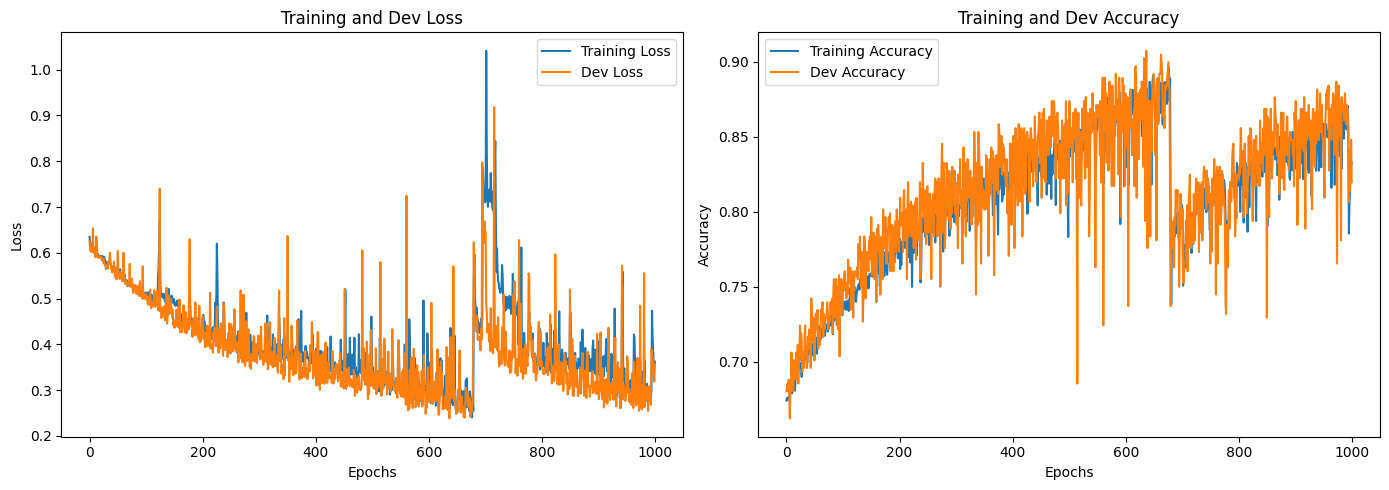

In [29]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and Dev loss
ax[0].plot(train_losses, label='Training Loss')
ax[0].plot(dev_losses, label='Dev Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Dev Loss')
ax[0].legend()

# Plot training and Dev accuracy
ax[1].plot(train_accuracy, label='Training Accuracy')
ax[1].plot(dev_accuracy, label='Dev Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Dev Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

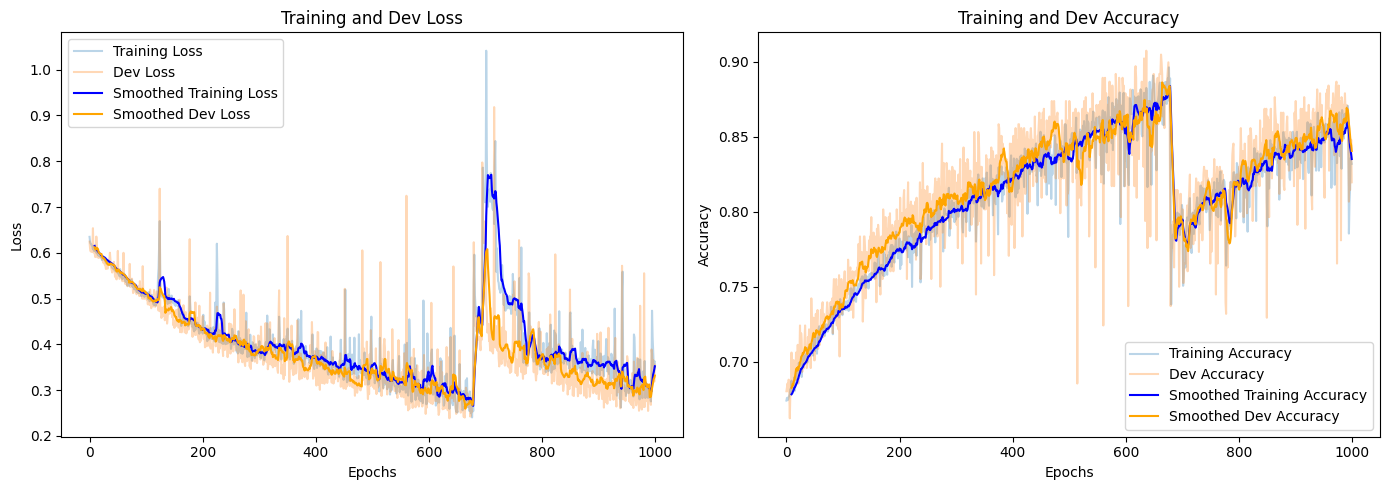

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_losses, dev_losses, train_accuracy, and dev_accuracy are defined

# Convert lists to pandas Series
train_losses_series = pd.Series(train_losses)
dev_losses_series = pd.Series(dev_losses)
train_accuracy_series = pd.Series(train_accuracy)
dev_accuracy_series = pd.Series(dev_accuracy)

# Calculate moving averages
window_size = 10  # Change this depending on the granularity of smoothing you need
smooth_train_losses = train_losses_series.rolling(window=window_size).mean()
smooth_dev_losses = dev_losses_series.rolling(window=window_size).mean()
smooth_train_accuracy = train_accuracy_series.rolling(window=window_size).mean()
smooth_dev_accuracy = dev_accuracy_series.rolling(window=window_size).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and Dev loss with moving averages
ax[0].plot(train_losses, label='Training Loss', alpha=0.3)
ax[0].plot(dev_losses, label='Dev Loss', alpha=0.3)
ax[0].plot(smooth_train_losses, label='Smoothed Training Loss', color='blue')
ax[0].plot(smooth_dev_losses, label='Smoothed Dev Loss', color='orange')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Dev Loss')
ax[0].legend()

# Plot training and Dev accuracy with moving averages
ax[1].plot(train_accuracy, label='Training Accuracy', alpha=0.3)
ax[1].plot(dev_accuracy, label='Dev Accuracy', alpha=0.3)
ax[1].plot(smooth_train_accuracy, label='Smoothed Training Accuracy', color='blue')
ax[1].plot(smooth_dev_accuracy, label='Smoothed Dev Accuracy', color='orange')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Dev Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [32]:

model.eval()
with torch.no_grad():
  test_running_losses = []
  test_total = 0
  test_correct = 0
  for iteration, (embeddings, labels) in enumerate(test_dataloader):

    # Move tensors to the appropriate testice
    embeddings = embeddings.to('cuda')
    labels = labels.to('cuda')

    outputs = model(embeddings)
    outputs = outputs.squeeze()  # Ensure output shape matches label shape

    loss = criterion(outputs, labels.float())

    # Convert outputs to predicted labels (0 or 1 based on threshold 0.5)
    predicted_labels = (outputs > 0.5).float()

    # Calculate accuracy
    test_total += labels.size(0)
    test_correct += (predicted_labels == labels).sum().item()
    test_running_losses.append(loss.item())

print(f'TEST: Loss: {sum(test_running_losses)/len(test_running_losses)} Acc: {test_correct/test_total}')

TEST: Loss: 3.0428738681475322 Acc: 0.6327028676021964
